In [1]:
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

PLOTS=True

In [2]:
test=1 #2,3

In [3]:
Nbins=200
Npoles=3
Nmeasures=1000  # 10000
meas=np.empty(Npoles, dtype=np.object)
meas[:]=[],[],[]
meas0=[]
meas1=[]
meas2=[]

In [4]:
for i in np.arange(Nmeasures)+1:
    fname = 'MockMeasures_2PCF_Test{}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{}_{}.fits'.format(test,test,i)
    file = fits.open(fname)
    table = file[1].data.copy()
        
    meas0.append(table['XI0'])
    meas1.append(table['XI2'])
    meas2.append(table['XI4'])
    if i==1:
        scale = table['SCALE']
    del table
    file.close()

meas0=np.asarray(meas0).transpose()
meas1=np.asarray(meas1).transpose()
meas2=np.asarray(meas2).transpose()
    
measures=np.concatenate((meas0,meas1,meas2))

#transpose the matrices to have Nbin in the first entry and Nmeasures in the second one

In [5]:
# Covarince matrix
cov_xi = np.cov(measures)

In [6]:
# Correlation matrix
corr_xi = np.zeros((Nbins*Npoles,Nbins*Npoles),dtype=float)
for i in range(Nbins*Npoles):
    for j in range(Nbins*Npoles):
        corr_xi[i,j]=cov_xi[i,j]/(cov_xi[i,i]*cov_xi[j,j])**0.5

In [7]:
if test==1:
    sigs = [0.02, 0.02, 0.02]
    ls = [25, 50, 75]
elif test==2:
    sigs = [0.02, 0.01, 0.005]
    ls = [50, 50, 50]
else:
    sigs = [0.02, 0.01, 0.005]
    ls = [5, 5, 5]

In [8]:
# Definitions to build the covarince matrices based on Squared Exponential kernel
def covf(x1, x2, sig, l):
    return sig**2.*np.exp(-(x1 - x2)**2./(2.*l**2.))

def covf1f2(x1, x2, sig1, l1, sig2, l2):
    return (np.sqrt(2.*l1*l2)*np.exp(-(np.sqrt((x1 - x2)**2.)**2./(l1**2. + l2**2.)))*sig1*sig2)/np.sqrt(l1**2. + l2**2.)

In [9]:
# Theoretical covariance matrix
cov_th = np.zeros((Nbins*Npoles,Nbins*Npoles),dtype=float)
for i in range(Nbins*Npoles):
    for j in range(Nbins*Npoles):
        cov_th[i,j] = covf1f2(scale[i-int(i/Nbins)*Nbins],scale[j-int(j/Nbins)*Nbins],sigs[int(i/Nbins)],ls[int(i/Nbins)],sigs[int(j/Nbins)],ls[int(j/Nbins)])

In [10]:
norm_residuals = np.zeros_like(cov_th)
for i in range(Nbins*Npoles):
    for j in range(Nbins*Npoles):
        rho2 = cov_th[i,j]/(np.sqrt(cov_th[i,i]*cov_th[j,j]))
        norm_residuals[i,j]=(cov_th[i,j]-cov_xi[i,j])*np.sqrt((Nmeasures-1.)/((1.+rho2)*cov_th[i,i]*cov_th[j,j]))

rms_deviation=np.std(norm_residuals.reshape((Nbins*Npoles)**2))

print("rms deviation of normalized residuals:{}".format(rms_deviation))

if rms_deviation<1.1:
    print("PASSED")
else:
    print("FAILED")

rms deviation of normalized residuals:0.70561009398
PASSED


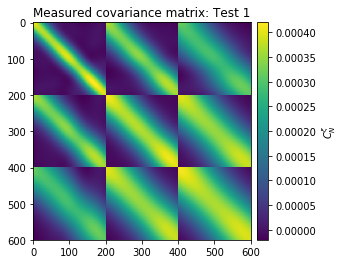

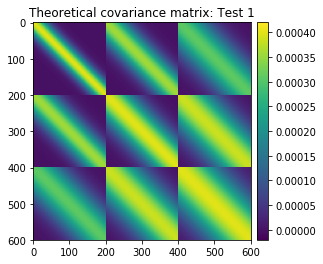

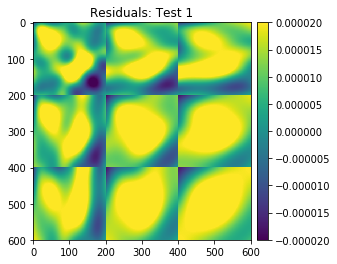

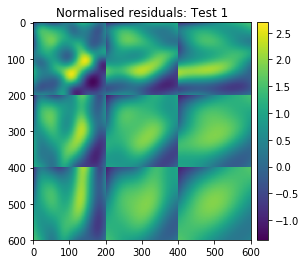

In [11]:
if PLOTS:

    gratio = (1. + 5. ** 0.5) / 2.

    dpi = 300
    #climit=max(np.max(theoretical_covariance),np.max(measured_covariance))
    cmin = -np.max(cov_th)*0.05
    cmax =  np.max(cov_th)*1.05
    

    # Matrix plot of measured covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('Measured covariance matrix: Test {}'.format(test))
    plt.imshow(cov_xi, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    cbar.set_label(r'$ C^{\xi}_{N}$')
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Matrix plot of theoretical covariance matrix
    fig = plt.figure(figsize=(6,4))
    plt.title('Theoretical covariance matrix: Test {}'.format(test))
    plt.imshow(cov_th, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()

    # Matrix plot of residuals
    fig = plt.figure(figsize=(6,4))
    plt.title('Residuals: Test {}'.format(test))
    plt.imshow(cov_th-cov_xi, vmin=cmin, vmax=-cmin)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()
    
    
    cmin = np.min(norm_residuals)*1.05
    cmax =  np.max(norm_residuals)*1.05
    

    # Matrix plot of normalised residuals
    fig = plt.figure(figsize=(6,4))
    plt.title('Normalised residuals: Test {}'.format(test))
    plt.imshow(norm_residuals, vmin=cmin, vmax=cmax)
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    # PLOTNAME = 'Test%s_Measured_Matrix.png'%test
    # plt.savefig(PLOTNAME,dpi = dpi)
    plt.show()